## Import necessary packages

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from utils import *
from model import SiameseNetwork
from loss import ContrastiveLoss
from dataset import ATATContrast
from torchsummary import summary
from matplotlib import pyplot as plt
import os
from glob import glob
import random
from sklearn.metrics import classification_report
import shutil
from tqdm import tqdm

# Prepare the data file

In [2]:
os.mkdir("train_test_val")
os.mkdir("train_test_val/train")
os.mkdir("train_test_val/test")
os.mkdir("train_test_val/val")

data=os.listdir("../archive (2)")
data.remove("README")

#train
rs=random.sample(data,32)
for i in rs:
    shutil.copytree(f"../archive (2)/{i}",f"train_test_val/train/{i}")
    data.remove(i)

#test
rs=random.sample(data,4)
for i in rs:
    shutil.copytree(f"../archive (2)/{i}",f"train_test_val/test/{i}")
    data.remove(i)

#valid
rs=random.sample(data,4)
for i in rs:
    shutil.copytree(f"../archive (2)/{i}",f"train_test_val/valid/{i}")
    data.remove(i)

## Initialize batch size and hyperparameters
The margin and threshold were changed to perform well on the validation set

In [4]:
path = 'train_test_val'

## Initialize parameters
bs = 32
lr = 1e-3
threshold = 0.1
margin = 1.0
epochs = 20

## Initialize network variables

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("the device being used is:",device)

## Initialize network
model = SiameseNetwork()
model = model.to(device)

model.apply(initialize_weights)

## Initialize optimizer
optim = torch.optim.Adam(model.parameters(),lr=lr)

## Initialize scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optim,5,gamma=0.7)

## Initialize loss
criterion = ContrastiveLoss(margin)

the device being used is: mps


## Create Datasets and Dataloaders

In [6]:
## Initialize datasets and dataloaders
train_transforms = torchvision.transforms.Compose([
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomRotation(25),
            torchvision.transforms.Grayscale(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.5], [0.5])
        ])

valid_transforms = torchvision.transforms.Compose([
            torchvision.transforms.Grayscale(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.5], [0.5])
        ])

test_transforms = torchvision.transforms.Compose([
            torchvision.transforms.Grayscale(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.5], [0.5])
        ])

train_ds = ATATContrast(ImageFolder(root = path + '/train',transform=train_transforms))
valid_ds = ATATContrast(ImageFolder(root = path + '/valid',transform=valid_transforms))
test_ds = ATATContrast(ImageFolder(root = path + '/test',transform=test_transforms))

train_dl = DataLoader(train_ds,batch_size=bs)
valid_dl = DataLoader(valid_ds,batch_size=bs)
test_dl = DataLoader(test_ds,batch_size=bs)

## Train the model

In [7]:
train_loss = []
valid_loss = []
for epoch in range(epochs):
    train_epoch_loss = 0
    model.train()    
      
    for i,(input1,input2,target) in enumerate(tqdm(train_dl, colour = 'GREEN',desc="Training  ",ncols=100)):
        optim.zero_grad()
        output1,output2 = model(input1.to(device),input2.to(device))
        out = model(input1.to(device),input2.to(device))
        
        loss = criterion(output1,output2,target.to(device))
        train_epoch_loss += loss.item()
        loss.backward()
        optim.step()
    
    train_epoch_loss /= len(train_ds)
    train_loss.append(train_epoch_loss)    

    valid_epoch_loss = 0
    val_pos_accuracy = 0
    val_neg_accuracy = 0
    num_pos = 0
    num_neg = 0
    model.eval()

    for i,(input1,input2,target) in enumerate(tqdm(valid_dl, colour = 'GREEN',desc="Validating",ncols=100)):
        output1,output2 = model(input1.to(device),input2.to(device))
        loss = criterion(output1,output2,target.to(device))
        valid_epoch_loss += loss.item()
        pos_acc,pos_sum,neg_acc,neg_sum = evaluate_pair(output1,output2,target.to(device),threshold)
        val_pos_accuracy+=pos_acc
        val_neg_accuracy+=neg_acc
        num_pos+=pos_sum
        num_neg+=neg_sum

    valid_epoch_loss /= len(valid_ds)
    val_pos_accuracy /= num_pos
    val_neg_accuracy /= num_neg

    valid_loss.append(valid_epoch_loss)

    print("Epoch [{}/{}] ----> Training loss :{} \n".format(epoch+1,epochs,train_epoch_loss))
    print("Validation loss :{} \t\t\t P Acc : {}, N Acc: {}\n".format(valid_epoch_loss,val_pos_accuracy,val_neg_accuracy))
    


Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.74it/s]


Epoch [1/20] ----> Training loss :0.014286955911666155 

Validation loss :0.02212805226445198 			 P Acc : 0.8947368421052632, N Acc: 0.5714285714285714



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.56it/s]


Epoch [2/20] ----> Training loss :0.00891274146270007 

Validation loss :0.013666153699159623 			 P Acc : 1.0, N Acc: 0.5625



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.46it/s]


Epoch [3/20] ----> Training loss :0.004886496909239213 

Validation loss :0.020312038809061052 			 P Acc : 1.0, N Acc: 0.5



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.73it/s]


Epoch [4/20] ----> Training loss :0.006031837671889662 

Validation loss :0.02580217607319355 			 P Acc : 1.0, N Acc: 0.4



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.60it/s]


Epoch [5/20] ----> Training loss :0.005628695734776557 

Validation loss :0.015393326431512833 			 P Acc : 1.0, N Acc: 0.5833333333333334



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.72it/s]


Epoch [6/20] ----> Training loss :0.00533623638912104 

Validation loss :0.017394839227199553 			 P Acc : 1.0, N Acc: 0.5357142857142857



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.48it/s]


Epoch [7/20] ----> Training loss :0.0052208734152372925 

Validation loss :0.01095147356390953 			 P Acc : 1.0, N Acc: 0.5555555555555556



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.14it/s]


Epoch [8/20] ----> Training loss :0.009657792537473142 

Validation loss :0.017968342080712317 			 P Acc : 1.0, N Acc: 0.45



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.75it/s]


Epoch [9/20] ----> Training loss :0.006773150992020849 

Validation loss :0.026561895757913588 			 P Acc : 1.0, N Acc: 0.5



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.66it/s]


Epoch [10/20] ----> Training loss :0.005719413094266201 

Validation loss :0.02127797082066536 			 P Acc : 1.0, N Acc: 0.4782608695652174



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.50it/s]


Epoch [11/20] ----> Training loss :0.005126690515317023 

Validation loss :0.01965642124414444 			 P Acc : 1.0, N Acc: 0.4444444444444444



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.41it/s]


Epoch [12/20] ----> Training loss :0.006290319410618394 

Validation loss :0.016069404408335687 			 P Acc : 0.8636363636363636, N Acc: 0.5555555555555556



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.17it/s]


Epoch [13/20] ----> Training loss :0.004643617283704771 

Validation loss :0.024999431893229486 			 P Acc : 1.0, N Acc: 0.3



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.72it/s]


Epoch [14/20] ----> Training loss :0.005058152151468676 

Validation loss :0.01960344463586807 			 P Acc : 1.0, N Acc: 0.35



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.56it/s]


Epoch [15/20] ----> Training loss :0.005509945063386113 

Validation loss :0.01581762880086899 			 P Acc : 1.0, N Acc: 0.5217391304347826



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.58it/s]


Epoch [16/20] ----> Training loss :0.004768347388016991 

Validation loss :0.010970454290509224 			 P Acc : 1.0, N Acc: 0.5789473684210527



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.59it/s]


Epoch [17/20] ----> Training loss :0.004229470124118962 

Validation loss :0.019550029933452607 			 P Acc : 1.0, N Acc: 0.47368421052631576



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.43it/s]


Epoch [18/20] ----> Training loss :0.004816688770370092 

Validation loss :0.018052510172128677 			 P Acc : 1.0, N Acc: 0.5555555555555556



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.82it/s]


Epoch [19/20] ----> Training loss :0.004383664852502989 

Validation loss :0.022678551077842713 			 P Acc : 1.0, N Acc: 0.391304347826087



Validating: 100%|█████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.71it/s]

Epoch [20/20] ----> Training loss :0.0039286188720325296 

Validation loss :0.021874740719795227 			 P Acc : 1.0, N Acc: 0.5238095238095238



## Plot losses

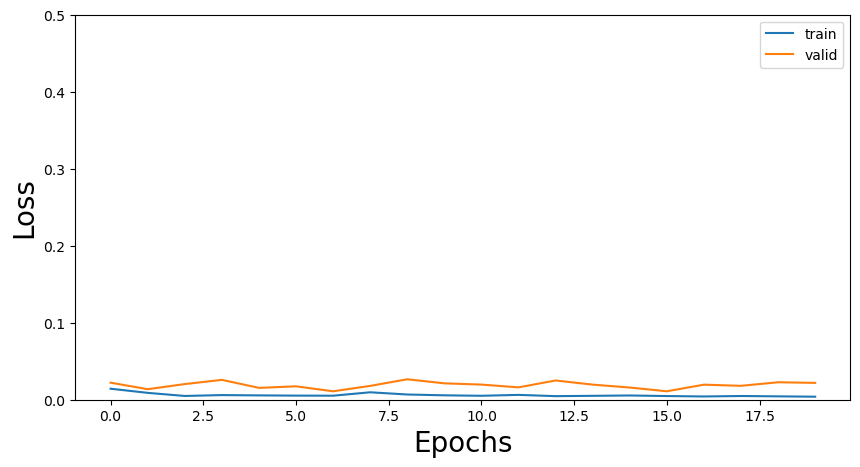

In [8]:
plt.figure(figsize = (10,5))
plt.plot(train_loss,label = 'train')
plt.plot(valid_loss,label = 'valid')
plt.xlabel("Epochs",size = 20)
plt.ylabel("Loss", size = 20)
plt.ylim(0,0.5)
plt.legend()
plt.show()

## Plot images from test set and compare distances

In [9]:
def show(img,ax,d):
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    ax.set_title("Dissimilarity:"+str(round(d[0],5)),fontweight = "bold", size = 24)
    ax.set_xticks([])
    ax.set_yticks([])

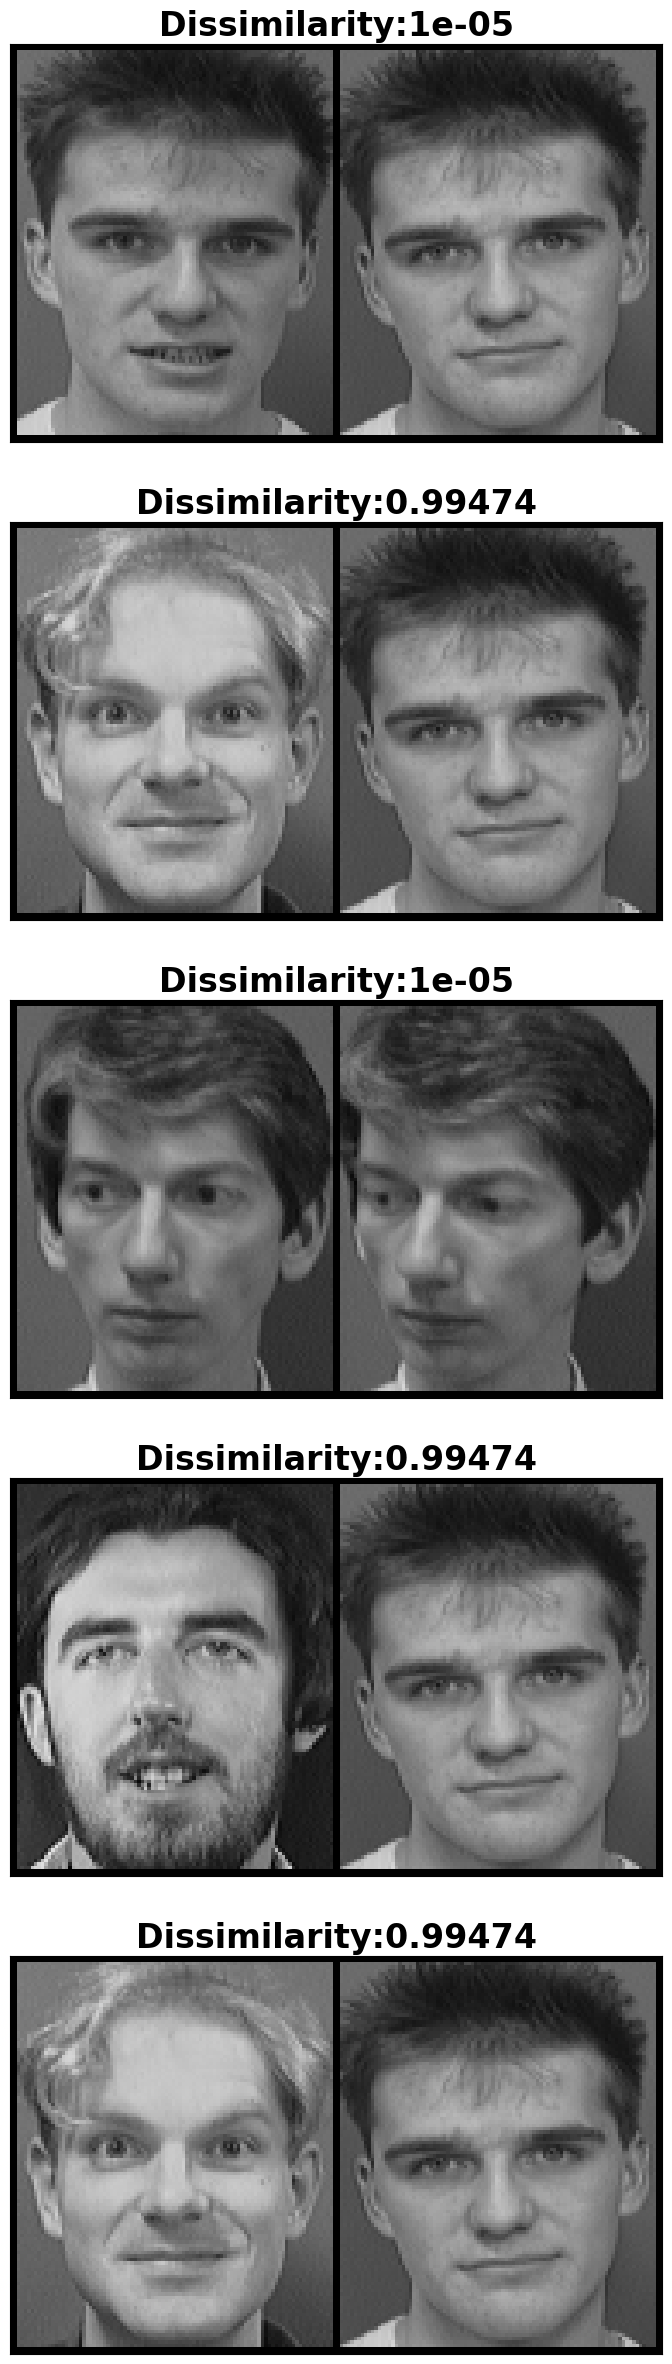

In [29]:
invTrans = torchvision.transforms.Compose([ torchvision.transforms.Normalize(mean = [ 0.],
                                                     std = [ 1/0.5]),
                                torchvision.transforms.Normalize(mean = [ -0.5],
                                                     std = [ 1.]),
                               ])

fig,ax = plt.subplots(5,1,figsize = (30,30))
for i in range(5):
    idx = np.random.randint(0,len(valid_ds))
    input1,input2,target = valid_ds[idx]
    model=model.to(device)
    output1,output2 = model(input1.unsqueeze(0).to(device),input2.unsqueeze(0).to(device))
    input1=invTrans(input1)
    input2=invTrans(input2)
    grid = torchvision.utils.make_grid([input1,input2])
    euclidean_distance = F.pairwise_distance(output1,output2)

    show(grid,ax[i],euclidean_distance.cpu().detach().numpy())
plt.show()

In [33]:
model=model.to(device)
preds=[]
actual=[]
for input1,input2,target in train_ds:
    actual.append(target)
    output1,output2 = model(input1.unsqueeze(0).to(device),input2.unsqueeze(0).to(device))
    pred=int(F.pairwise_distance(output1,output2)>threshold)
    preds.append(pred)
    
print(classification_report(preds,actual))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90       169
           1       0.89      0.88      0.88       151

    accuracy                           0.89       320
   macro avg       0.89      0.89      0.89       320
weighted avg       0.89      0.89      0.89       320



In [40]:
model=model.to(device)
preds=[]
actual=[]
for input1,input2,target in test_ds:
    actual.append(target)
    output1,output2 = model(input1.unsqueeze(0).to(device),input2.unsqueeze(0).to(device))
    pred=int(F.pairwise_distance(output1,output2)>threshold)
    preds.append(pred)
    
print(classification_report(preds,actual))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85        15
           1       0.95      0.84      0.89        25

    accuracy                           0.88        40
   macro avg       0.87      0.89      0.87        40
weighted avg       0.89      0.88      0.88        40



In [50]:
model=model.to(device)
preds=[]
actual=[]
for input1,input2,target in valid_ds:
    actual.append(target)
    output1,output2 = model(input1.unsqueeze(0).to(device),input2.unsqueeze(0).to(device))
    pred=int(F.pairwise_distance(output1,output2)>threshold)
    preds.append(pred)
    
print(classification_report(preds,actual))

              precision    recall  f1-score   support

           0       1.00      0.70      0.82        30
           1       0.53      1.00      0.69        10

    accuracy                           0.78        40
   macro avg       0.76      0.85      0.76        40
weighted avg       0.88      0.78      0.79        40



## Save the trained model for future usage

In [14]:
torch.save(model.state_dict(),'./siameseNetowrk_final.pt')

In [15]:
new_model = SiameseNetwork()
new_model.load_state_dict(torch.load('./siameseNetowrk_final.pt'))
new_model.eval()

SiameseNetwork(
  (resnet): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(